In [1]:
# Kredit: https://www.kaggle.com/datasets/crawford/emnist/data?select=emnist-balanced-mapping.txt
# Notebook ini dibangun atas tautan diatas.
# Notebook dibuat oleh: https://www.kaggle.com/jonathanimmanuel

In [2]:
# Impor library yang diperlukan
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

In [3]:
# Map ini diperlukan untuk mengubah label menjadi huruf dan angka
maps = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "A",
    11: "B",
    12: "C",
    13: "D",
    14: "E",
    15: "F",
    16: "G",
    17: "H",
    18: "I",
    19: "J",
    20: "K",
    21: "L",
    22: "M",
    23: "N",
    24: "O",
    25: "P",
    26: "Q",
    27: "R",
    28: "S",
    29: "T",
    30: "U",
    31: "V",
    32: "W",
    33: "X",
    34: "Y",
    35: "Z",
    36: "a",
    37: "b",
    38: "d",
    39: "e",
    40: "f",
    41: "g",
    42: "h",
    43: "n",
    44: "q",
    45: "r",
    46: "t"
}

datadir = "./data"

In [4]:
# Fungsi untuk impor data
def import_data():
    # Impor data
    train = pd.read_csv(os.path.join(datadir, "emnist-balanced-train.csv"), header=None)
    test = pd.read_csv(os.path.join(datadir, "emnist-balanced-test.csv"), header=None)

    # Pecah data
    x_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    x_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values

    # Bentuk ulang data
    x_train = x_train.reshape(x_train.shape[0], 28, 28)
    x_test = x_test.reshape(x_test.shape[0], 28, 28)

    return (x_train, y_train), (x_test, y_test)

In [5]:
# Fungsi untuk memuat data
def load_data():
    (x_train, y_train), (x_test, y_test) = import_data()

    # Normalisasi data
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # Enkodasi one-hot
    y_train = tf.keras.utils.to_categorical(y_train, 47)
    y_test = tf.keras.utils.to_categorical(y_test, 47)

    return (x_train, y_train), (x_test, y_test)

In [6]:
# Mari kita lihat data yang telah kita muat
(x_train, y_train), (x_test, y_test) = load_data()
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

x_train: (112800, 28, 28)
y_train: (112800, 47)


In [7]:
# Fungsi untuk menampilkan data
def display_data(x, y):
    # Tampilkan data
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i], cmap="gray")
        plt.title(maps[np.argmax(y[i])])
        plt.axis("off")
    plt.show()

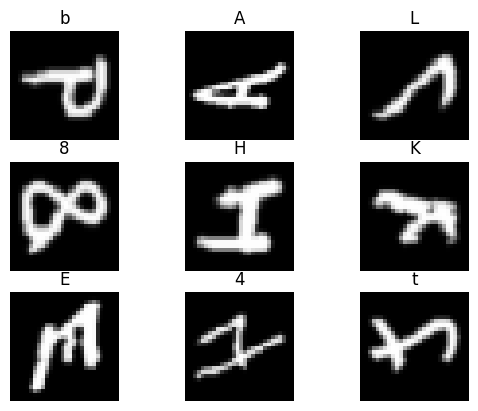

In [8]:
# Tampilkan data secara acak
random_sample = np.random.randint(0, x_train.shape[0], 9)
display_data(x_train[random_sample], y_train[random_sample])

In [9]:
# Gambarnya diputar dan terbalik, jadi kita perlu memutar dan membalikkannya kembali
def rotate_data(x):
    # Rotate the data
    x_rotated = []
    for i in range(x.shape[0]):
        img = Image.fromarray(x[i])
        img = img.rotate(90)
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
        x_rotated.append(np.array(img))
    x_rotated = np.array(x_rotated)

    return x_rotated

In [10]:
# Mari kita putar datanya
rotated_x_train = rotate_data(x_train)
rotated_x_test = rotate_data(x_test)

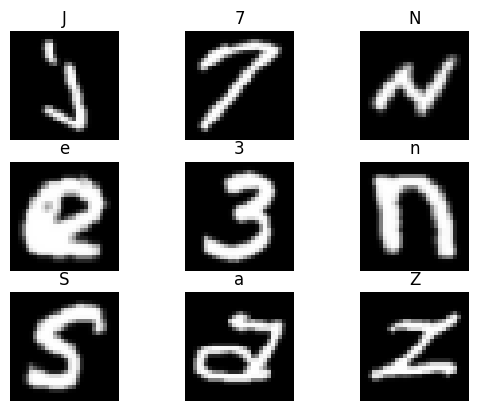

In [11]:
# Tampilkan data secara acak lagi
random_sample = np.random.randint(0, rotated_x_train.shape[0], 9)
display_data(rotated_x_train[random_sample], y_train[random_sample])

In [12]:
# Selesaikan datanya dengan cache, shuffle, batch, dan prefetch
dataset = tf.data.Dataset.from_tensor_slices((rotated_x_train, y_train), )
dataset = dataset.shuffle(10000)
dataset = dataset.cache()
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((rotated_x_test, y_test))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
# Sekarang datanya terlihat bagus, mari kita bangun modelnya
def build_model_dense():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(47, activation="softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [14]:
def build_model_conv():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (4, 4), activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((4, 4)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(47, activation="softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [15]:
def build_model_conv_full():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(47, activation="softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [16]:
# Bangun modelnya
model_1 = build_model_dense()
model_2 = build_model_conv()
model_3 = build_model_conv_full()
print(model_1.summary())
print(model_2.summary())
print(model_3.summary())




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 47)                12079     
                                                                 
Total params: 145583 (568.68 KB)
Trainable params: 14

In [17]:
# Callback
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]

In [18]:
# Latih modelnya
history1 = model_1.fit(dataset, validation_data=test_dataset, epochs=20, callbacks=callbacks, verbose=2)
history2 = model_2.fit(dataset, validation_data=test_dataset, epochs=20, callbacks=callbacks, verbose=2)
history3 = model_3.fit(dataset, validation_data=test_dataset, epochs=20, callbacks=callbacks, verbose=2)

Epoch 1/20


3525/3525 - 34s - loss: 1.1591 - accuracy: 0.6523 - val_loss: 0.6925 - val_accuracy: 0.7812 - 34s/epoch - 10ms/step
Epoch 2/20
3525/3525 - 38s - loss: 0.7721 - accuracy: 0.7530 - val_loss: 0.5981 - val_accuracy: 0.8052 - 38s/epoch - 11ms/step
Epoch 3/20
3525/3525 - 29s - loss: 0.6950 - accuracy: 0.7733 - val_loss: 0.5535 - val_accuracy: 0.8185 - 29s/epoch - 8ms/step
Epoch 4/20
3525/3525 - 23s - loss: 0.6536 - accuracy: 0.7842 - val_loss: 0.5484 - val_accuracy: 0.8191 - 23s/epoch - 7ms/step
Epoch 5/20
3525/3525 - 31s - loss: 0.6266 - accuracy: 0.7904 - val_loss: 0.5254 - val_accuracy: 0.8263 - 31s/epoch - 9ms/step
Epoch 6/20
3525/3525 - 27s - loss: 0.6084 - accuracy: 0.7967 - val_loss: 0.5223 - val_accuracy: 0.8264 - 27s/epoch - 8ms/step
Epoch 7/20
3525/3525 - 24s - loss: 0.5927 - accuracy: 0.7989 - val_loss: 0.5087 - val_accuracy: 0.8277 - 24s/epoch - 7ms/step
Epoch 8/20
3525/3525 - 22s - loss: 0.5815 - accuracy: 0.8039 - val_loss: 0.5134 - val_accuracy: 0.8314 - 22s/epoch

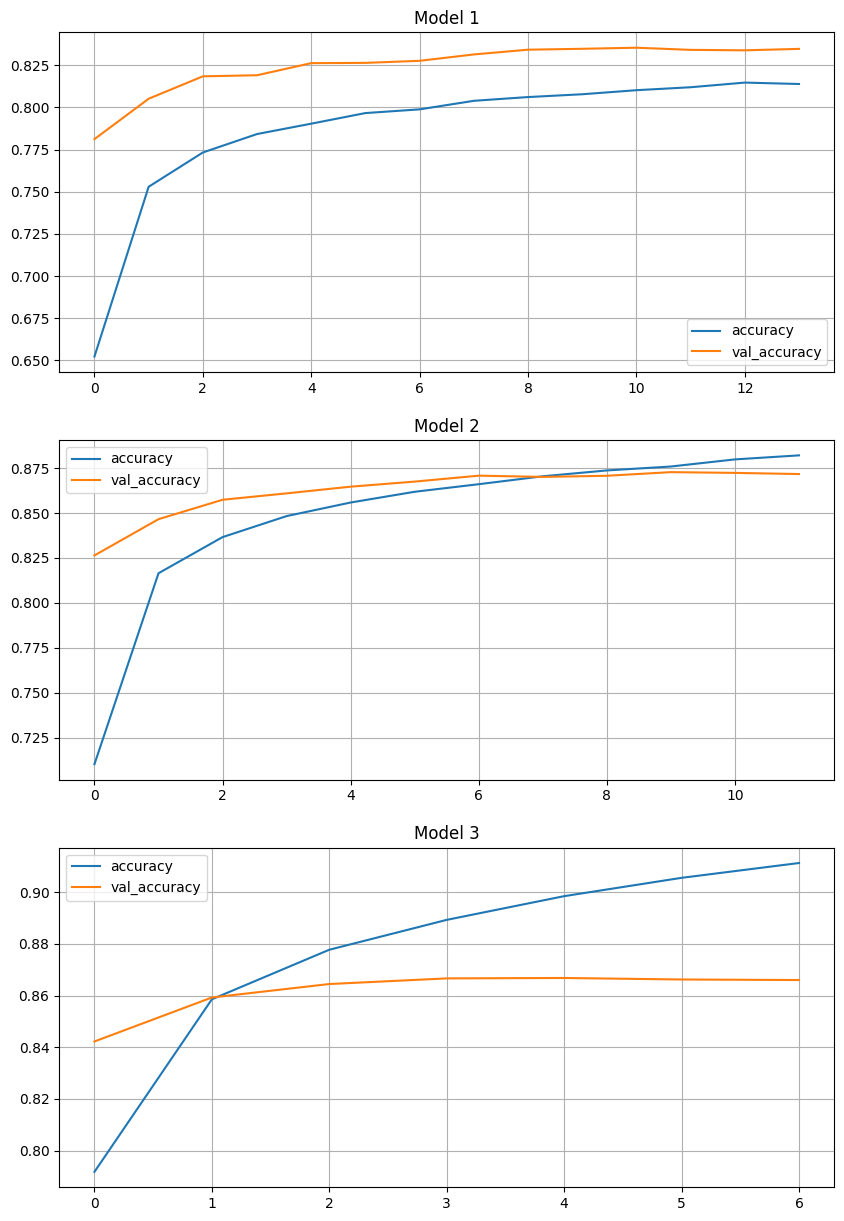

In [19]:
# Tampilkan grafik akurasi
ax, fig = plt.subplots(3, 1, figsize=(10, 15))
fig[0].plot(history1.history["accuracy"], label="accuracy")
fig[0].plot(history1.history["val_accuracy"], label="val_accuracy")
fig[0].set_title("Model 1")
fig[0].legend()
fig[0].grid()

fig[1].plot(history2.history["accuracy"], label="accuracy")
fig[1].plot(history2.history["val_accuracy"], label="val_accuracy")
fig[1].set_title("Model 2")
fig[1].legend()
fig[1].grid()

fig[2].plot(history3.history["accuracy"], label="accuracy")
fig[2].plot(history3.history["val_accuracy"], label="val_accuracy")
fig[2].set_title("Model 3")
fig[2].legend()
fig[2].grid()

plt.show()

588/588 [==============================] - 7s 10ms/step


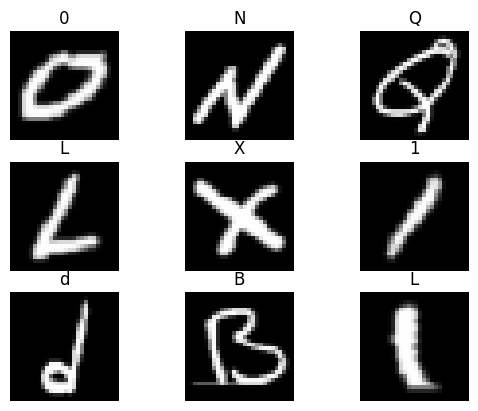

In [22]:
# Tampilkan prediksi data dengan nilai aslinya
predictions = model_3.predict(rotated_x_test)
random_sample = np.random.randint(0, rotated_x_test.shape[0], 9)
display_data(rotated_x_test[random_sample], predictions[random_sample])

In [23]:
# Dapat dimengerti bahwa beberapa gambar mungkin tidak diprediksi dengan benar karena kesamaan karakter
# Tetapi modelnya dapat memprediksi sebagian besar gambar dengan benar

# Simpan modelnya
model_3.save("emnist_model.keras")